In [29]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

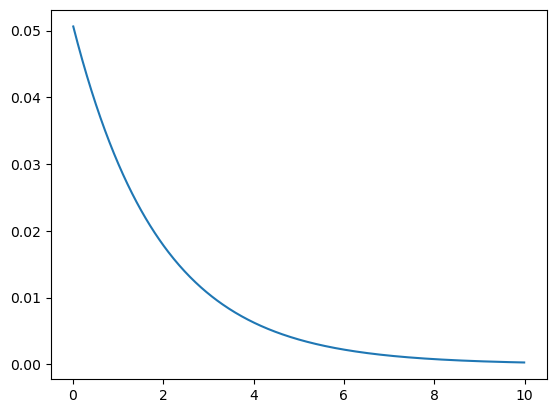

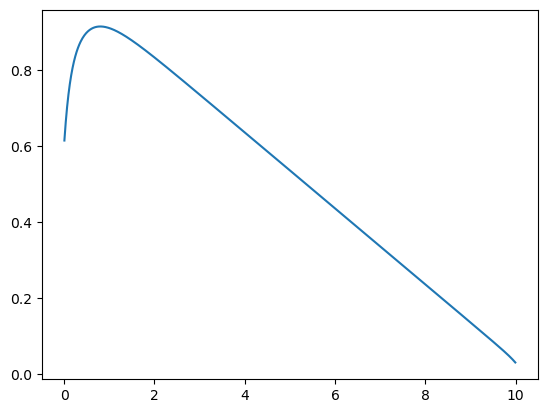

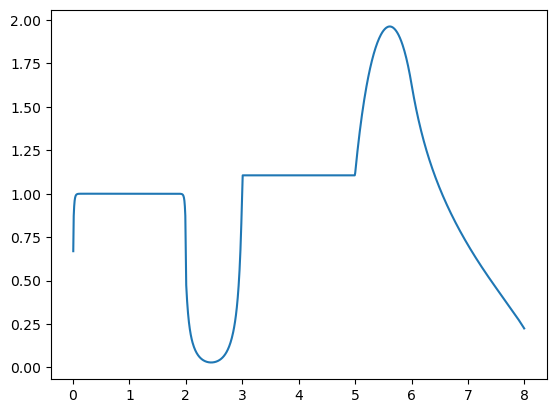

In [ ]:
# class Quadrature:
#     def __init__(self, order):
#         # NOTE: order needs to be even to avoid mu = 0
#         assert order % 2 == 0, "Quadrature order must be even"
#         self.order = order
#         self.mus = None
#         self.weights = None
        
#     def compute_quadrature(self):
#         # Compute the quadrature points and weights
#         # In 1D slab geometry, the quadrature points are the Legendre roots
#         # and the weights are the corresponding Legendre weights
#         (self.mus, self.weights) = scipy.special.roots_legendre(self.order)

#     def return_quadrature(self):
#         return (self.mus, self.weights)

class Quadrature:
    def __init__(self, order):
        assert order % 2 == 0, "Quadrature order must be even"
        self.mus, self.weights = scipy.special.roots_legendre(order)

    def get_quadrature(self):
        return self.mus, self.weights

        
# class Mesh:
#     def __init__(self, max_mesh_width, num_points):
#         self.max_mesh_width = max_mesh_width
#         self.num_points = num_points 
#         self.mesh = None
#         self.dx = None
#         self.num_cells = None
    
#     def create_mesh(self):
#         # Number of mesh intervals and mesh spacing
#         (self.mesh, self.dx) = np.linspace(0, self.max_mesh_width, self.num_points, 
#                                            retstep=True)
#         self.num_cells = int(self.max_mesh_width/self.dx)
    
#     def return_mesh(self):
#         return (self.mesh, self.dx, self.num_cells)

class Mesh:
    def __init__(self, max_mesh_width, num_points):
        self.mesh, self.dx = np.linspace(0, max_mesh_width, num_points, retstep=True)
        self.num_cells = num_points - 1

    def get_mesh(self):
        return self.mesh, self.dx, self.num_cells


# class MaterialProperties:
#     def __init__(self, sigma_t_zones, sigma_s_zones, q_zones, mesh):
#         # We assume that the zone cutoffs are identical for each type of 
#         # xs and external soure

#         # Dictionary where keys are tuples zone = (zone_begin, zone_end) and 
#         # values are sigma_t for that zone
#         self.sigma_t_zones = sigma_t_zones 
#         # Same as above, but for sigma_s
#         self.sigma_s_zones = sigma_s_zones
#         # Same as above, but for external volumetric sources 
#         self.q_zones       = q_zones 

#         self.mesh = mesh

#         # Arrays to store xs and external source values for each cell
#         self.sigma_t = np.zeros((mesh.size - 1,))
#         self.sigma_s = np.zeros((mesh.size - 1,))
#         self.ext_src = np.zeros((mesh.size - 1,))

#     def find_xs_and_sources_for_mesh(self):
#         # Loop through the mesh points and assign xs's and source values
#         for i in np.arange(self.mesh.size - 1):
#             mesh_midpoint = 0.5 * (self.mesh[i] + self.mesh[i + 1])
#             # print(mesh_midpoint)
#             for (zone, sigma_t_val) in self.sigma_t_zones.items():
#                 # print(zone[0], mesh_midpoint, zone[1])
#                 if zone[0] <= mesh_midpoint <= zone[1]:
#                     self.sigma_t[i] = sigma_t_val
#                     self.sigma_s[i] = self.sigma_s_zones[zone]
#                     self.ext_src[i] = self.q_zones[zone]

#     def return_xs_and_sources_for_mesh(self):
#         return (self.sigma_t, self.sigma_s, self.ext_src)   

class MaterialProperties:
    def __init__(self, sigma_t_zones, sigma_s_zones, q_zones, mesh):
        num_cells = mesh.size - 1
        self.sigma_t = np.zeros(num_cells)
        self.sigma_s = np.zeros(num_cells)
        self.ext_src = np.zeros(num_cells)

        # Compute midpoints of cells
        midpoints = 0.5 * (mesh[:-1] + mesh[1:])

        # Assign material properties efficiently using NumPy boolean masks
        for zone, sigma_t in sigma_t_zones.items():
            mask = (zone[0] <= midpoints) & (midpoints <= zone[1])
            self.sigma_t[mask] = sigma_t
            self.sigma_s[mask] = sigma_s_zones[zone]
            self.ext_src[mask] = q_zones[zone]

    def return_xs_and_sources_for_mesh(self):
        return self.sigma_t, self.sigma_s, self.ext_src

class Solver:
    def __init__(self, psi_left, psi_right, sigma_t_zones, sigma_s_zones, zones_q,
                max_mesh_width, num_mesh_points, quad_order,
                solver_type="diamond-difference"):
        self.psi_left = psi_left 
        self.psi_right = psi_right
        self.sigma_t_zones = sigma_t_zones
        self.sigma_s_zones = sigma_s_zones
        self.zones_q       = zones_q
        self.max_mesh_width = max_mesh_width
        self.num_mesh_points = num_mesh_points
        self.quad_order     = quad_order
        self.solver_type    = solver_type

        # Extract mesh
        self.mesh_obj = Mesh(self.max_mesh_width, self.num_mesh_points)
        self.mesh, self.mesh_dx, self.mesh_num_cells = self.mesh_obj.get_mesh()

        # Extract mesh material properties
        self.mat_props_obj = MaterialProperties(self.sigma_t_zones, self.sigma_s_zones,
                                            self.zones_q, self.mesh)
        self.sigma_t, self.sigma_s, self.ext_src = self.mat_props_obj.return_xs_and_sources_for_mesh()

        # Extract quadrature rules
        self.quad_rules_obj = Quadrature(self.quad_order)
        self.mus, self.weights = self.quad_rules_obj.get_quadrature()

        # Initial guesses to perform source iteration
        self.curr_scalar_fluxes = np.full((self.mesh_num_cells, ), np.log(2))
        self.new_scalar_fluxes  = np.zeros_like(self.curr_scalar_fluxes)

        self.eps = 1e-5 # Relative error tolerance
        self.iter_count = 0 # Iteration counter
        self.max_scalar_flux_rel_err = np.max(np.abs((self.new_scalar_fluxes - self.curr_scalar_fluxes)/
                                                 self.curr_scalar_fluxes))
        
    def plot_scalar_fluxes(self):
        mesh_centers = 0.5 * (self.mesh[:-1] + self.mesh[1:])
        plt.figure()
        plt.plot(mesh_centers, self.curr_scalar_fluxes)
        plt.show()

    def run(self):
        # Perform source iteration until scalar flux relative error (in all mesh cells)
        # between previous and current scalar flux iterates is below eps
        while True:
            self.iter_count += 1

            # Compute source term
            curr_source_term = 0.5 * (self.ext_src + self.sigma_s * self.curr_scalar_fluxes)

            # Loop over angles
            for mu_d, mu in enumerate(self.mus):
                # Determine the traversal order
                traversing_forward = mu  < 0.0

                starting_cell_idx = 0 if traversing_forward else (self.mesh_num_cells - 1)
                ending_cell_idx = self.mesh_num_cells if traversing_forward else -1
                cell_step_idx = 1 if traversing_forward else -1

                # psi_{d, i} = a*psi_{d, i+1/2} + (1-a) psi_{d, i-1/2}, 0 <= a <= 1
                # Step scheme: a = 0 for mu > 0 and a = 1 for mu < 0
                # Diamond-difference scheme: a = 1/2
                a = None
                if self.solver_type == 'diamond_difference':
                    a = 0.5
                else: # Step scheme
                    a = 0 if traversing_forward else 1 
                
                # Extract incident flux, depending on traversal order
                psi_d_in = self.psi_left[mu_d] if traversing_forward else self.psi_right[mu_d]

                # Useful term to compute 
                abs_mu = np.abs(mu)

                # Loop over cells
                for i in np.arange(starting_cell_idx, ending_cell_idx, cell_step_idx):
                    psi_d_out = (curr_source_term[i] * (self.mesh_dx/abs_mu) + \
                                 (1 - (1 - a) * self.sigma_t[i] * (self.mesh_dx/abs_mu)) * psi_d_in) / \
                                    (1 + a * self.sigma_t[i] * self.mesh_dx/abs_mu)
                    psi_d = (1-a) * psi_d_in + a * psi_d_out
                    # print(psi_d)
                    # print(f"psi_d = {psi_d}, psi_d_out = {psi_d_out}, psi_d_in = {psi_d_in}")
                    psi_d_in = psi_d_out

                    # Update scalar flux, cell by cell
                    self.new_scalar_fluxes[i] += psi_d * self.weights[mu_d]


            # Compute relative error between two most recent scalar flux iterates
            # print(self.curr_scalar_fluxes)
            # print(self.new_scalar_fluxes)
            self.max_scalar_flux_rel_err = np.max(np.abs((self.new_scalar_fluxes - self.curr_scalar_fluxes)/ \
                                                  self.curr_scalar_fluxes))
            
            # Update scalar fluxes
            self.curr_scalar_fluxes = np.copy(self.new_scalar_fluxes)
            self.new_scalar_fluxes[:] = 0.0
            
            if ((self.max_scalar_flux_rel_err <= self.eps)):
                break
            
        # Plot the scalar fluxes 
        self.plot_scalar_fluxes()

# class Solver:
#     def __init__(self, psi_left, psi_right, sigma_t_zones, sigma_s_zones, q_zones, width, num_points, quad_order, solver_type="diamond-difference"):
#         self.psi_left, self.psi_right = psi_left, psi_right
#         self.solver_type, self.eps, self.max_iters = solver_type, 1e-6, 100

#         # Initialize Mesh, Material Properties, and Quadrature
#         self.mesh, self.dx, self.num_cells = Mesh(width, num_points).get_mesh()
#         self.sigma_t, self.sigma_s, self.ext_src = MaterialProperties(sigma_t_zones, sigma_s_zones, q_zones, self.mesh).return_xs_and_sources_for_mesh()
#         self.mus, self.weights = Quadrature(quad_order).get_quadrature()

#         # Initialize scalar flux storage
#         self.iter_count = 0
#         self.curr_scalar_flux = np.full(self.num_cells, np.log(2))
#         self.new_scalar_flux = np.zeros_like(self.curr_scalar_flux)

#     def plot_scalar_flux(self):
#         plt.plot(0.5 * (self.mesh[:-1] + self.mesh[1:]), self.curr_scalar_flux)
#         plt.xlabel("Position")
#         plt.ylabel("Scalar Flux")
#         plt.show()

#     def run(self):
#         # print(self.sigma_t, self.sigma_s)
#         # print(self.curr_scalar_flux)
#         while True:
#             self.iter_count += 1

#             source_term = 0.5 * (self.ext_src + self.sigma_s * self.curr_scalar_flux)

#             for mu_d, mu in enumerate(self.mus):
#                 forward = mu > 0.0
#                 start, end, step = (0, self.num_cells, 1) if forward else (self.num_cells - 1, -1, -1)
#                 psi_d_in = self.psi_left[mu_d] if forward else self.psi_right[mu_d]

#                 a = 0.5 if self.solver_type == "diamond-difference" else (0 if forward else 1)
#                 dx_mu = self.dx / np.abs(mu)

#                 for i in range(start, end, step):
#                     sigma_t_dx_mu = self.sigma_t[i] * dx_mu
#                     psi_d_out = (source_term[i] * dx_mu + (1 - (1 - a) * sigma_t_dx_mu) * psi_d_in) / (1 + a * sigma_t_dx_mu)
#                     psi_d = (1 - a) * psi_d_in + a * psi_d_out
#                     psi_d_in = psi_d_out
#                     # if (psi_d == 0.0):
#                         # break
#                     self.new_scalar_flux[i] += psi_d * self.weights[mu_d]

#             # if self.new_scalar_flux == 0:
#             #     break
#             # print(self.curr_scalar_flux)
#             max_rel_err = np.max(np.abs((self.new_scalar_flux - self.curr_scalar_flux) / self.curr_scalar_flux))
#             # print(self.new_scalar_flux)

#             if (self.iter_count % 20 == 0):
#                 print(f"Relative error: {max_rel_err}")
#             # Update fluxes
#             self.curr_scalar_flux[:] = self.new_scalar_flux
#             self.new_scalar_flux.fill(0)

#             if max_rel_err <= self.eps:
#                 break

#         self.plot_scalar_flux()

if __name__ == '__main__':
    # # Problem 2
    mesh_width = 10.0
    num_mesh_points = 500

    quadrature_order = 8

    psi_left = np.zeros((quadrature_order, ))
    psi_left[0] = 0.5

    psi_right = np.zeros((quadrature_order, ))
    # psi_right[:] = 0.5

    sigma_t_zones = {}
    sigma_t_zones[(0.0, mesh_width)] = 0.5

    sigma_s_zones = {}
    sigma_s_zones[(0.0, mesh_width)] = 0.0

    q_zones = {}
    q_zones[(0.0, mesh_width)] = 0.0

    problem_2_solver = Solver(psi_left, psi_right, sigma_t_zones, sigma_s_zones, 
                              q_zones,
                              mesh_width, num_mesh_points, quadrature_order,
                              solver_type="step")
    problem_2_solver.run()

    ####
    # Problem 3
    mesh_width = 10.0
    num_mesh_points = 1000

    quadrature_order = 8

    psi_left = np.zeros((quadrature_order, ))
    psi_left[0] = 2.25

    psi_right = np.zeros((quadrature_order, ))
    # psi_right[:] = 0.5

    sigma_t_zones = {}
    sigma_t_zones[(0.0, mesh_width)] = 2.0

    sigma_s_zones = {}
    sigma_s_zones[(0.0, mesh_width)] = 2.0

    q_zones = {}
    q_zones[(0.0, mesh_width)] = 0.0

    problem_3_solver = Solver(psi_left, psi_right, sigma_t_zones, sigma_s_zones, 
                              q_zones, mesh_width, num_mesh_points, quadrature_order,
                              solver_type="step")
    problem_3_solver.run()

    # Reed problem
    mesh_width = 8.0

    quadrature_order = 8
    psi_left = np.zeros((quadrature_order, ))
    psi_right = np.zeros((quadrature_order, ))

    sigma_t_zones = {}
    sigma_t_zones[(0.0, 2.0)] = 50.0
    sigma_t_zones[(2.0, 3.0)] = 5.0
    sigma_t_zones[(3.0, 5.0)] = 0.0
    sigma_t_zones[(5.0, 6.0)] = 1.0
    sigma_t_zones[(6.0, 8.0)] = 1.0

    sigma_s_zones = {}
    sigma_s_zones[(0.0, 2.0)] = 0.0
    sigma_s_zones[(2.0, 3.0)] = 0.0
    sigma_s_zones[(3.0, 5.0)] = 0.0
    sigma_s_zones[(5.0, 6.0)] = 0.9
    sigma_s_zones[(6.0, 8.0)] = 0.9

    q_zones = {}
    q_zones[(0.0, 2.0)] = 50.0
    q_zones[(2.0, 3.0)] = 0.0
    q_zones[(3.0, 5.0)] = 0.0
    q_zones[(5.0, 6.0)] = 1.0
    q_zones[(6.0, 8.0)] = 0.0

    problem_5_solver = Solver(psi_left, psi_right, sigma_t_zones, sigma_s_zones,
                              q_zones, mesh_width, num_mesh_points, quadrature_order,
                              solver_type="diamond_difference")
    problem_5_solver.run()
    

